In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical
from data import data_dirs as data_env

from result_visualization import show_results

from fastai.vision import (
    Learner, load_learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,   # matplotlib.pyplot
    nn,    # torch.nn
    optim  # torch.optim
)
from fastai.callbacks.mem import PeakMemMetric

from torchvision.utils import save_image

import cv2

import numpy as np

import torch

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
learner = load_learner("/home/dmitri/Documents/model_weights/linknet34/", "linknet34_const_full_e25_exp")

In [3]:
# learner = learner.load("/home/dmitri/Documents/model_weights/linknet34/linknet34_student_4src_ops_full_e50_wghts", )

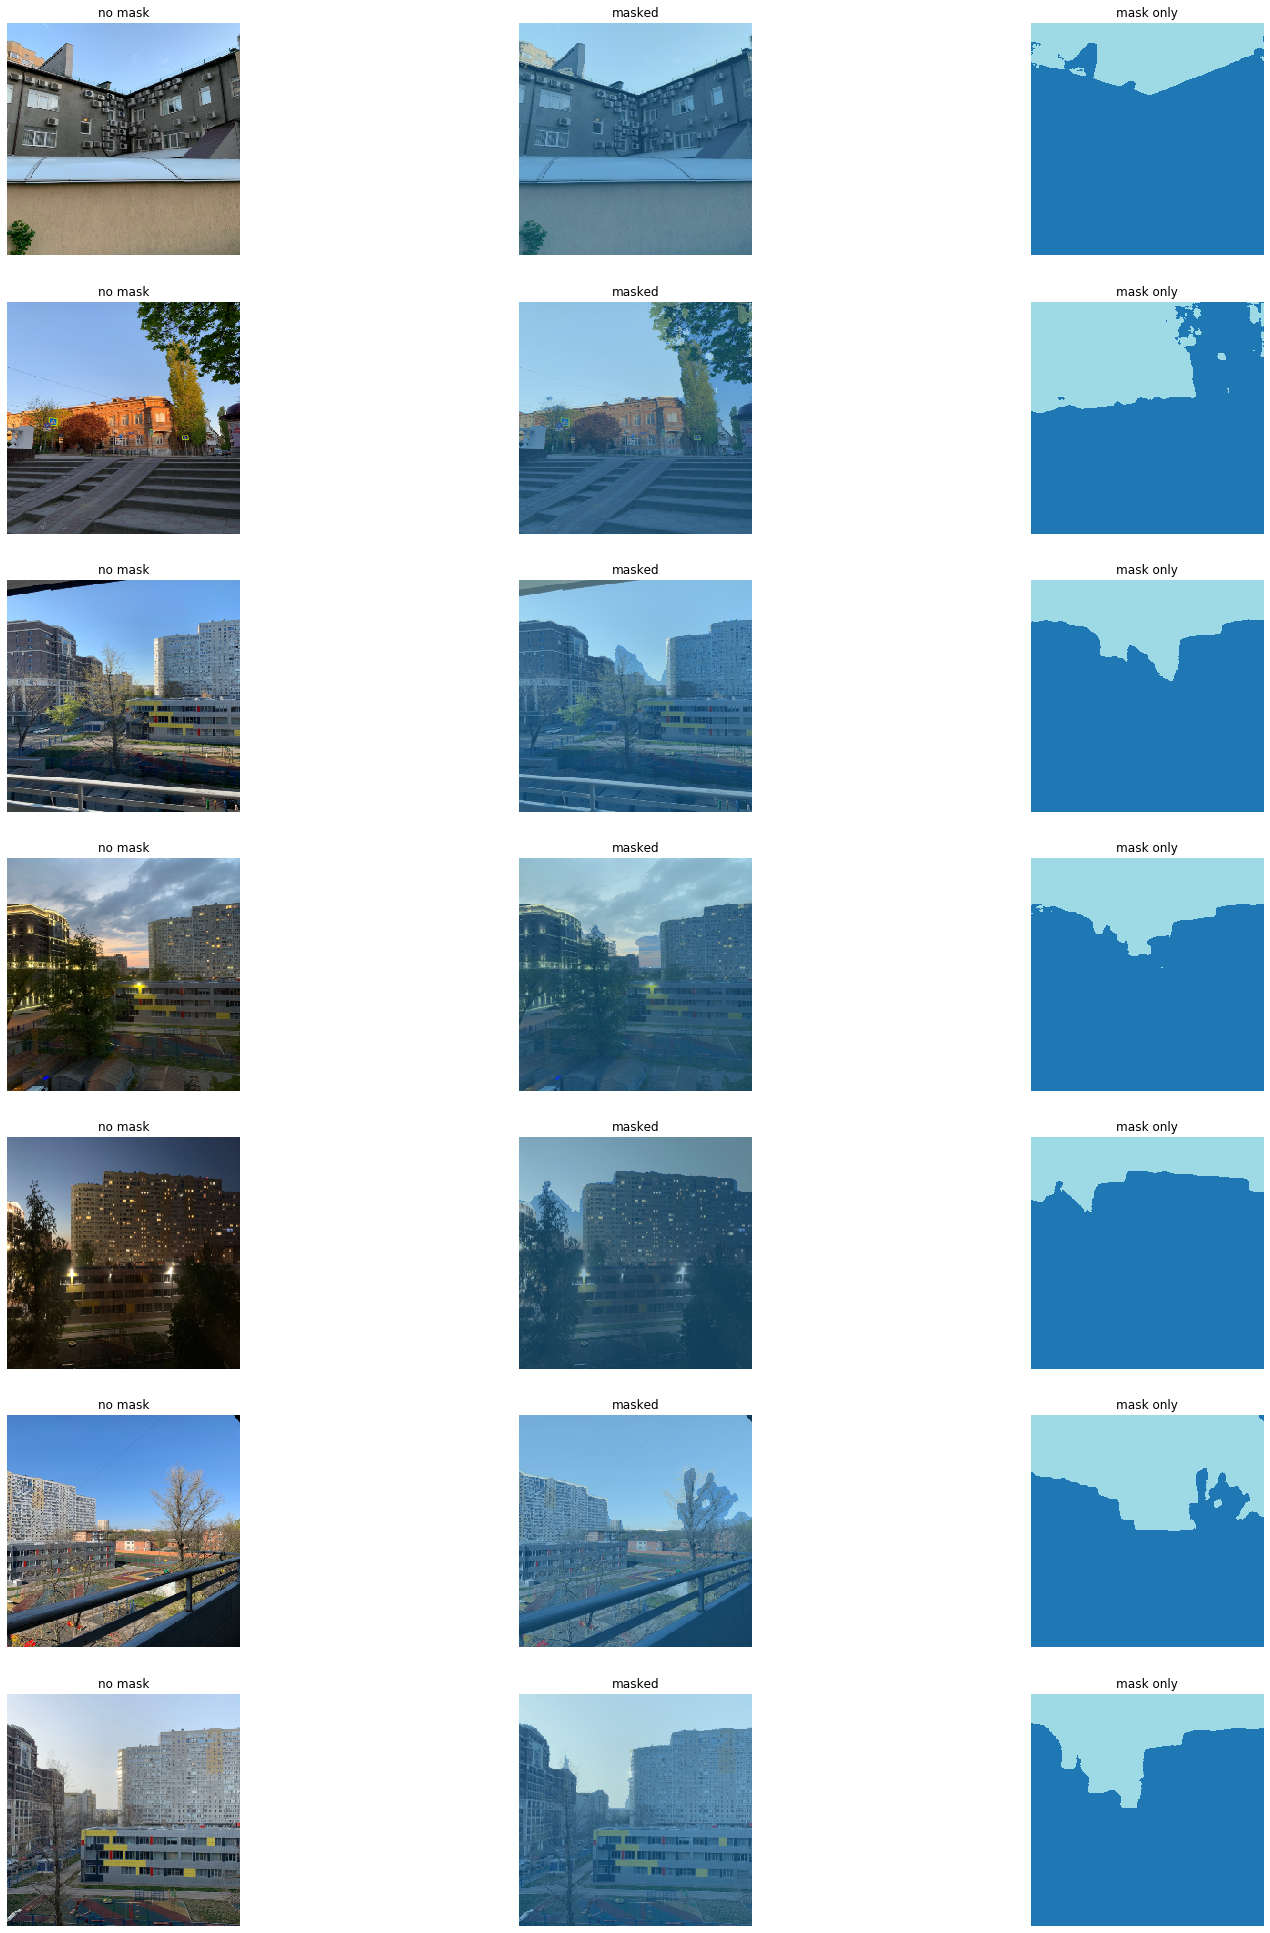

In [4]:
sizes= 256

test_data = (
    ImageList
    .from_folder(data_env.get_subdir("test iPhoneXR images"))
    .split_by_folder()
    .label_empty()
    .add_test_folder(test_folder="./")
    .transform(get_transforms(do_flip=False), size=sizes, resize_method=ResizeMethod.SQUISH)
    .databunch(bs=1)
    .normalize(imagenet_stats)
)


show_results(test_data, learner)

In [30]:
_, raw_mask, se = learner.predict(test_data.test_dl.get(0))
raw_mask *= 255
save_image(raw_mask.to(float), "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/image_mask.png")

In [33]:
# raw_mask = se.max(dim=0)[1].unsqueeze(0)

In [34]:
AREA_THRESHOLD = 600

lable_np_array = raw_mask.numpy()
    
blur = cv2.GaussianBlur(lable_np_array.astype(np.uint8),(5,5),0).squeeze(0)
ret,thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Contour detection
_, contours, hierarchy = cv2.findContours( thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter contour by area
contour_list = []
area_threshold = AREA_THRESHOLD

for contour in contours:
    area = cv2.contourArea(contour)
    if area > area_threshold :
        contour_list.append(contour)

# Making binary mask by contour        
countMask = np.zeros(thresh.shape, dtype='uint8')
cv2.drawContours(countMask, contour_list, -1, (255, 255, 255), cv2.FILLED)

# Restore accuracy of board between sky and other objects
mask_rev = np.add(cv2.bitwise_not(thresh), cv2.bitwise_not(countMask))
_,mask_rev = cv2.threshold(mask_rev, 0, 255, cv2.THRESH_BINARY)
mask = cv2.bitwise_not(mask_rev) 

save_image(torch.from_numpy(mask).to('cpu', torch.float), "/home/dmitri/dev/BachelorDiploma/thesis/mmcs_sfedu_thesis/img/image_mask_after_correction.png")